In [1]:
%config InlineBackend.figure_format = 'svg'

import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from typing import Sequence, Dict, Tuple

from abm1559.utils import constants
gamma = 500000
constants["SIMPLE_TRANSACTION_GAS"] = gamma

from abm1559.config import rng

from abm1559.txs import Tx1559

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_demand,
)

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 1000)
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product

#  x | x | x | x | too late
#    0   1   2   3   4

class UserSharded(User1559):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, **kwargs)
        rng = kwargs["rng"]
        window_size = kwargs["window_size"]
        self.publishing_time = rng.choice(range(window_size+1))
        self.inclusion_time = -1
    
    def publish(self, env):
        current_block = env["current_block"]
        window_size = env["window_size"]
        if self.inclusion_time == -1:
            return False
        if current_block - self.inclusion_time >= window_size:
            return False
        if current_block - self.inclusion_time == self.publishing_time:
#             print(f"User waking up at {self.wakeup_block} publishing after {self.publishing_time} blocks at block {current_block}")
            return True
        return False
    
    def create_transaction(self, env):
        tx_params = self.decide_parameters(env)

        tx = TxSharded(
            sender = self.pub_key,
            tx_params = tx_params,
        )

        return tx
    
class UserShardedHonest(UserSharded):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, **kwargs)
        self.publishing_time = 0

class TxSharded(Tx1559):
    """
    Inherits from :py:class:`abm1559.txs.Transaction`. A 1559-type transaction.
    """

    def __init__(self, sender, tx_params, **kwargs):
        super().__init__(sender, tx_params, **kwargs)
        self.blob_published = False
        
    def publish_blob(self):
        self.blob_published = True
        
    def __str__(self):
        return f"Sharded Transaction {self.tx_hash.hex()}: max_fee {self.max_fee}, gas_premium {self.gas_premium}, gas_used {self.gas_used}, blob_published {self.blob_published}"
        
MAX_TX_POOL = 500
MIN_PREMIUM = 1e9

class TxPoolLimit(TxPool):
    
    def __init__(self, max_txs=MAX_TX_POOL, min_premium=MIN_PREMIUM, **kwargs):
        super().__init__(**kwargs)
        self.max_txs = max_txs
        self.min_premium = MIN_PREMIUM
    
    def add_txs(self, txs: Sequence[Tx1559], env: dict) -> Sequence[Tx1559]:
        for tx in txs:
            self.txs[tx.tx_hash] = tx
                    
        if self.pool_length() > self.max_txs:
            sorted_txs = sorted(self.txs.values(), key = lambda tx: -tx.tip(env))
            self.empty_pool()
            self.add_txs(sorted_txs[0:self.max_txs], env)
            return sorted_txs[self.max_txs:]
        
        return []

class TxPool1559(TxPoolLimit):
    
    def select_transactions(self, env, user_pool=None, rng=rng) -> Sequence[Tx1559]:
        # Miner side
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])

        valid_txs = [tx for tx in self.txs.values() if tx.is_valid(env) and tx.tip(env) >= self.min_premium]
        rng.shuffle(valid_txs)

        sorted_valid_demand = sorted(
            valid_txs,
            key = lambda tx: -tx.tip(env)
        )
        selected_txs = sorted_valid_demand[0:max_tx_in_block]

        return selected_txs
    
def update_basefee_sharded(chain: Chain, basefee: int, window_size: int) -> int:
    """
    Basefee update rule

    Args:
        block (Block): The previous block
        basefee (int): The current basefee

    Returns:
        int: The new basefee
    """
    
    head = chain.current_head
    adjustment_quotient = constants["BASEFEE_MAX_CHANGE_DENOMINATOR"] * window_size
    new_basefee = basefee
    
    for w in range(window_size):
        block = chain.blocks[head]
        gas_used = sum([tx.gas_used for tx in block.txs if tx.blob_published])
#         print(f"Gas used by block head - {w} (height {len(chain.blocks) - w - 1}): {gas_used}")
        if gas_used == constants["TARGET_GAS_USED"]:
            pass
        elif gas_used > constants["TARGET_GAS_USED"]:
            gas_delta = gas_used - constants["TARGET_GAS_USED"]
            fee_delta = max(new_basefee * gas_delta // constants["TARGET_GAS_USED"] // adjustment_quotient, 1)
            new_basefee = new_basefee + fee_delta
        else:
            gas_delta = constants["TARGET_GAS_USED"] - gas_used
            fee_delta = new_basefee * gas_delta // constants["TARGET_GAS_USED"] // adjustment_quotient
            new_basefee = new_basefee - fee_delta
        head = block.parent_hash
        if head == b'\x00\x00\x00\x00\x00\x00\x00\x00':
                break
    
    return new_basefee
    
def simulate_sharded(demand_scenario, txpool, UserClass, window_size = 4, extra_metrics = None, rng = rng, silent=False):
    # Instantiate a couple of things
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    
    # `env` is the "environment" of the simulation
    env = {
        "basefee": 1 * 1e9,
        "current_block": None,
        "window_size": window_size,
    }

    for t in tqdm(range(len(demand_scenario)), disable=silent, desc="simulation loop", leave=False):
        
        # Sets current block
        env["current_block"] = t
        
        # Reset the random number generator with new seed to generate users with same values across runs
        rng = np.random.default_rng((2 ** t) * (3 ** 1))
        
        ### SIMULATION ###

        # We return some demand which on expectation yields `demand_scenario[t]` new users per round
        users = spawn_poisson_demand(t, demand_scenario[t], UserClass, rng=rng, window_size = window_size)
        
        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)

        # New transactions are added to the transaction pool
        # `evicted_txs` holds the transactions removed from the pool for lack of space
        pool_limit_evicted_txs = txpool.add_txs(decided_txs, env)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env, rng = rng)
        
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(
            txs = selected_txs, parent_hash = chain.current_head,
            height = t, basefee = env["basefee"]
        )
        
        # The block is added to the chain
        chain.add_block(block)
        
        # We ask publishers in blocks head:head-window_size if they want to publish
        head = chain.current_head
        
        # Set inclusion time
        for user in [user_pool.users[tx.sender] for tx in chain.blocks[chain.current_head].txs]:
            user.inclusion_time = env["current_block"]
        
        for w in range(window_size):
            block = chain.blocks[head]
            for tx in block.txs:
                sender = tx.sender
                if user_pool.users[sender].publish(env):
                    tx.publish_blob()
            head = block.parent_hash
            if head == b'\x00\x00\x00\x00\x00\x00\x00\x00':
                break
        
        ### METRICS ###                
        row_metrics = {
            "block": t,
            "users": len(users),
            "decided_txs": len(decided_txs),
            "pool_limit_evictions": len(pool_limit_evicted_txs),
            "included_txs": len(selected_txs),
            "basefee": env["basefee"] / 1e9, # to Gwei
            "pool_length": txpool.pool_length(),
            "gas_used": block.gas_used(),
        }
        
        if not extra_metrics is None:
            row_metrics = {
                **row_metrics,
                **extra_metrics(env, users, user_pool, txpool),
            }
        
        metrics.append(row_metrics)
        
        # Finally, basefee is updated and a new round starts
        env["basefee"] = update_basefee_sharded(chain, env["basefee"], env["window_size"])

    return (pd.DataFrame(metrics), user_pool, chain)

In [2]:
simulation_length = 2000
demand_scenario = [100 for i in range(simulation_length)]
txpool = TxPool1559()
(df, user_pool, chain) = simulate_sharded(demand_scenario, txpool, UserSharded)

total_size = sum([sum([tx.gas_used for tx in block.txs if tx.blob_published]) for block in chain.blocks.values()])
average_block_size = total_size / len(chain.blocks)

simulation loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Simple sharding model:

- User wakes up, wants to send a transaction (blob) of size 500,000. Value for transaction drawn from uniform distribution between 0 and 20 Gwei.
- Block target size is 12,500,000, i.e., 25 blobs max (limit 25,000,000, i.e, 50 blobs max). On average 100 users drawn between two blocks (congested state).
- User sends a 1559-style transaction: set max_priority_fee = 1 Gwei and max_fee = their value.
- Assume window_size = 4: delay to publish blob after inclusion in a block.
- Once the user is included in a block, we record their inclusion time. Each user randomly publishes their blob with delay 0, 1, 2, 3, or 4 blocks after their inclusion block
    - Delay = 0 => blob is published right away, counts in the very next basefee update.
    - Delay = 4 => User publishes their blob too late, the blob is never counted in any basefee update, counted as missing.
- Basefee updated according to the multiplicative formula in [note](https://notes.ethereum.org/@barnabe/Bk1zeDimK).

This is the average block size we record. Note that the target is 12.5M, so this average block size is way above.

In [3]:
average_block_size

20025250.0

<AxesSubplot:xlabel='block'>

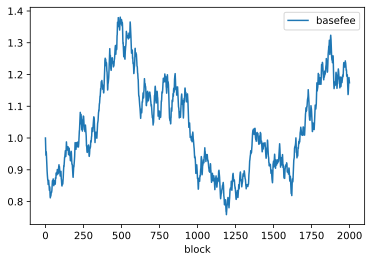

In [4]:
df.plot("block", "basefee")

The rolling window cannot target the correct average block size. Since blobs may be published later, either the gas used is currently correct, or underestimated. This implies that basefee is "too low" and over time too many blobs get in.

We redo the simulation with honest sharded users: always publish their blob with delay 0, basefee updates always done with the "correct" block size.

In [5]:
demand_scenario = [100 for i in range(simulation_length)]
txpool = TxPool1559()
(df, user_pool, chain) = simulate_sharded(demand_scenario, txpool, UserShardedHonest)

total_size = sum([sum([tx.gas_used for tx in block.txs if tx.blob_published]) for block in chain.blocks.values()])
average_block_size = total_size / len(chain.blocks)

simulation loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Now the average block size is much closer to target (~12.5M gas).

In [6]:
average_block_size

12663750.0

<AxesSubplot:xlabel='block'>

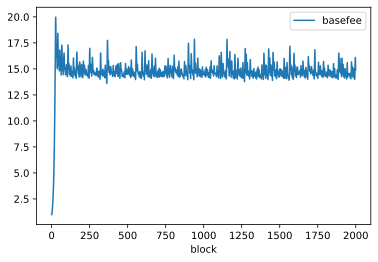

In [7]:
df.plot("block", "basefee")